### Курсовая работа

### -- Автор: Шенк Евгений Станиславович

Целевая метрика - money precision @ 5. Порог для уcпешной сдачи проекта money precision @ 5 > 20%

Бизнес ограничения в топ-5 товарах:
- Для каждого юзера 5 рекомендаций (иногда модели могут возвращать < 5)
- 2 новых товара (юзер никогда не покупал)
- 1 дорогой товар, > 7 долларов
- Все товары из разных категорий (категория - sub_commodity_desc)
- Стоимость каждого рекомендованного товара > 1 доллара

#### Описание:

Результат: 0.128 < 0.2:  
        Было перепробовано все: 
            - различные модели(als, bpr, own, 2 уровневая модель, предсказание по топ популярным) - без результатов
            - Различные переметры начальной фильтрации данных: по quantity,  sales_value, количество покупок, кол-во дней с последней покупки, мин-макс цена, кол-во отбираемых товаров - без результатов  
            - Взвешивания с различными параметрами и различные параметры в user-item матрице - без результатов
            - Различные фичи и гиперпараметры в модели 2-го уровня - без результатов
            - Попытка подглядеть в образцах  - без результатов (в одном обучение идет по валидациионной выборке, в другом не соблюдаются бизнесс требования(найти хоть 1 товар >7$ в конечных рекомендациях перебором по словарю с ценами из примера не удалось)

Данная модель в основном использует глобальный топ покупок, топ покупок каждого пользователь и немного own_recommender - даже так получить 0.2 метрики не удалось, хотя такое предсказание должно быть с максимальной метрикой для реальной работы скорее всего не годится.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Для категориальных переменных
from sklearn.preprocessing import LabelEncoder

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import recall, recall_at_k, precision, precision_at_k, money_precision_at_k
from src.utils import prefilter_items, postfilter_items, show_feature_importances, get_price_list, get_sub_commodity_desc_list, user_purchased_items_list
from src.recommenders import MainRecommender

In [2]:
np.random.seed(2177)

In [3]:
# Минимальная цена товара и количество товаров для предсказаний
min_price=1
take_n_popular=3000

In [4]:
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../data/product.csv')
user_features = pd.read_csv('../data/hh_demographic.csv')
data = data.drop(data[data['quantity']==0].index)

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недели -- 
val_lvl_1_size_weeks = 10
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [5]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features, take_n_popular=take_n_popular, min_price=min_price)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

C:\Users\Eugene\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
D:\Auress\Data_Science\Python_for_DS\Recommendation_systems\src\utils.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data[['item_id']].merge(df_grouped[['item_id', 'price']], how='left', on='item_id')['price']


Decreased # items from 81216 to 3001


In [6]:
# Словари с информацией:
item_id_to_price = get_price_list(data_train_lvl_1) # стоимость товара
item_id_to_sub_commodity = get_sub_commodity_desc_list(data_train_lvl_1, item_features) # категория товара
user_purchased_items = user_purchased_items_list(pd.concat([data_train_lvl_1, data_train_lvl_2]))#список товаров купленых юзером из трейна

In [7]:
# Запуск MainRecommender
recommender = MainRecommender(data_train_lvl_1, item_features, weighting=True)

In [8]:
# Embeddings
items_embeddings = recommender.items_emb_df
users_embeddings = recommender.users_emb_df

### Предсказания модели 1-ого уровня

In [9]:
users_lvl_1 = sorted(data_val_lvl_1['user_id'].unique().tolist())
result_lvl_1 = pd.DataFrame({'user_id': users_lvl_1})
result_lvl_1['own'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))
result_lvl_1['top_p'] = result_lvl_1['user_id'].apply(lambda x: recommender.top_purchases[recommender.top_purchases['user_id'] == x][:25]['item_id'].tolist())
result_lvl_1.head(2)

,user_id,own,top_p
0,1,"[995242, 9527290, 940947, 1004906, 1006184, 96...","[856942, 8090541, 9527290, 940947, 995242, 557..."
1,2,"[5569230, 1106523, 8090521, 1133018, 916122, 9...","[8090521, 5569230, 1106523, 940947, 1133018, 1..."


## Модель 2-ого уровня

In [10]:
users_lvl_2 = sorted(data_train_lvl_2['user_id'].unique().tolist())
users_lvl_2 = pd.DataFrame({'user_id': users_lvl_2})
users_lvl_2['candidates'] =result_lvl_1.apply(lambda x: np.concatenate([x['own'], x['top_p'], recommender.overall_top_purchases_exp[:25]]), axis=1)

users_lvl_2.head(2)

,user_id,candidates
0,1,"[995242, 9527290, 940947, 1004906, 1006184, 96..."
1,2,"[5569230, 1106523, 8090521, 1133018, 916122, 9..."


In [11]:
exp_rec = recommender.overall_top_purchases_exp[:10]
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'
users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)

users_lvl_2.head(2)

,user_id,item_id
0,1,995242.0
0,1,9527290.0


In [12]:
targets_lvl_2 = data_val_lvl_1[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 
targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')
targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop_duplicates(subset =['user_id', 'item_id'], keep = 'first', inplace = True)
targets_lvl_2.reset_index(drop=True, inplace= True)
targets_lvl_2.head(2)

,user_id,item_id,target
0,1,995242.0,1.0
1,1,9527290.0,0.0


In [13]:
data_train_lvl_1 = data_train_lvl_1.merge(item_features, on='item_id', how='left')
data_train_lvl_1 = data_train_lvl_1.merge(user_features, on='user_id', how='left')

data_train_lvl_2 = data_train_lvl_2[data_train_lvl_2['item_id'].isin(data_train_lvl_1['item_id'].unique())]

data_train_lvl_2 = data_train_lvl_2.merge(item_features, on='item_id', how='left')
data_train_lvl_2 = data_train_lvl_2.merge(user_features, on='user_id', how='left')

data_train_lvl_2.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,1639,40279042786,566,850102,1,7.99,441,0.0,36,82,0.0,0.0,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 20PK&24PK CAN CARB,12 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1639,40279042786,566,896862,1,3.99,441,0.0,36,82,0.0,0.0,1425,MEAT-PCKGD,National,BACON,ECONOMY,1 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Генерация фичей

In [14]:
    # Фичи из датасета
    def features_creation(data):
        # age_desc
        data.loc[(data['age_desc'] == '19-24'), 'age_desc'] = 19
        data.loc[(data['age_desc'] == '25-34'), 'age_desc'] = 25
        data.loc[(data['age_desc'] == '35-44'), 'age_desc'] = 35
        data.loc[(data['age_desc'] == '45-54'), 'age_desc'] = 45
        data.loc[(data['age_desc'] == '55-64'), 'age_desc'] = 55
        data.loc[(data['age_desc'] == '65+'), 'age_desc'] = 65
        data['age_desc'] = pd.to_numeric(data['age_desc'])
        # income_desc
        data.loc[(data['income_desc'] == 'Under 15K'), 'income_desc'] = 10
        data.loc[(data['income_desc'] == '15-24K'), 'income_desc'] = 15
        data.loc[(data['income_desc'] == '25-34K'), 'income_desc'] = 25
        data.loc[(data['income_desc'] == '35-49K'), 'income_desc'] = 35
        data.loc[(data['income_desc'] == '50-74K'), 'income_desc'] = 50
        data.loc[(data['income_desc'] == '75-99K'), 'income_desc'] = 75
        data.loc[(data['income_desc'] == '100-124K'), 'income_desc'] = 100
        data.loc[(data['income_desc'] == '125-149K'), 'income_desc'] = 125
        data.loc[(data['income_desc'] == '150-174K'), 'income_desc'] = 150
        data.loc[(data['income_desc'] == '175-199K'), 'income_desc'] = 175
        data.loc[(data['income_desc'] == '200-249K'), 'income_desc'] = 200
        data.loc[(data['income_desc'] == '250K+'), 'income_desc'] = 250
        data['income_desc'] = pd.to_numeric(data['income_desc'])
        # household_size_desc
        data.loc[(data['household_size_desc'] == '5+'), 'household_size_desc'] = 5
        data['household_size_desc'] = pd.to_numeric(data['household_size_desc'])
        # kid_category_desc
        data.loc[(data['kid_category_desc'] == 'None/Unknown'), 'kid_category_desc'] = 0
        data.loc[(data['kid_category_desc'] == '3+'), 'kid_category_desc'] = 3
        data['kid_category_desc'] = pd.to_numeric(data['kid_category_desc'])
        
        # price
        data['price'] = data['item_id'].apply(lambda x: item_id_to_price[x])
            
         # Add embeddings
        data = data.merge(users_embeddings, how='left', on='user_id')
        data = data.merge(items_embeddings, how='left', on='item_id')

        # fill NaN
        data.fillna(0, inplace=True)

        return data

In [15]:
# Количество покупок по категориям
def create_feature_u_1(df=data_train_lvl_2):
    feat_u_1 = df[['user_id', 'department']].copy()
    feat_u_1 = pd.get_dummies(feat_u_1)
    feat_u_1 = feat_u_1.groupby(by='user_id').sum()

    return feat_u_1

In [16]:
# Средний чек
def create_feature_u_2(df=data_train_lvl_2):
    feat_u_2 = df[['user_id', 'basket_id', 'sales_value']].copy()
    feat_u_2 = feat_u_2.groupby(by=['user_id', 'basket_id']).sum()
    feat_u_2 = feat_u_2.groupby(by=['user_id']).mean()
    feat_u_2.rename(columns={"sales_value": "average_bill"}, inplace=True)

    return feat_u_2

In [17]:
# Кол-во покупок в неделю
def create_feature_i_1(df=data_train_lvl_2):
    feat_i_1 = df[['item_id', 'quantity', 'week_no']].copy()
    feat_i_1 = feat_i_1[feat_i_1['quantity'] > 0]
    feat_i_1 = feat_i_1.groupby(by=['item_id', 'week_no']).sum()
    feat_i_1 = feat_i_1.groupby(by=['item_id']).mean()
    feat_i_1.rename(columns={"quantity": "quantity_per_week"}, inplace=True)

    return feat_i_1

In [18]:
# Средняя цена товара в категории
def create_feature_i_2(df=data_train_lvl_2):
    feat_i_2 = df[['item_id', 'quantity', 'sales_value', 'sub_commodity_desc']].copy()
    feat_i_2 = feat_i_2[feat_i_2['quantity'] > 0]
    feat_i_2['per_unit'] = feat_i_2['sales_value'] / feat_i_2['quantity']
    avr_per_comm = feat_i_2.groupby(by=['sub_commodity_desc']).mean()[['per_unit']].rename(columns={"per_unit": "avr_per_comm"})
    
    return avr_per_comm

In [19]:
# (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
def create_feature_u_i_1(avr_per_comm, df=data_train_lvl_2):
    feat_u_i_1 = df[['user_id', 'item_id', 'quantity', 'sales_value', 'sub_commodity_desc']].copy()
    feat_u_i_1 = feat_u_i_1[feat_u_i_1['quantity'] > 0]
    feat_u_i_1 = feat_u_i_1.groupby(by=['user_id', 'item_id', 'sub_commodity_desc'], as_index = False).sum()
    feat_u_i_1 = feat_u_i_1.merge(avr_per_comm, on=['sub_commodity_desc'], how='left')  # avr_per_comm посчитан выше в feat_i_2
    feat_u_i_1['per_unit'] = feat_u_i_1['sales_value'] / feat_u_i_1['quantity']
    feat_u_i_1['diff_unit_avr'] = feat_u_i_1['per_unit'] - feat_u_i_1['avr_per_comm']
    feat_u_i_1 = feat_u_i_1[['user_id', 'item_id', 'diff_unit_avr']]

    return feat_u_i_1

In [20]:
# (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
def create_feature_u_i_2(df=data_train_lvl_2):
    feat_u_i_2 = df[['user_id', 'quantity', 'sub_commodity_desc', 'week_no']].copy()
    feat_u_i_2 = feat_u_i_2[feat_u_i_2['quantity'] > 0]
    total_u = feat_u_i_2.groupby(by=['sub_commodity_desc', 'week_no']).sum()[['quantity']].rename(columns={"quantity": "quantity_per_week"})
    feat_u_i_2 = feat_u_i_2.groupby(by=['user_id', 'sub_commodity_desc', 'week_no'], as_index = False).sum()
    feat_u_i_2 = feat_u_i_2.merge(total_u, on=['sub_commodity_desc', 'week_no'], how='left')
    feat_u_i_2 = feat_u_i_2.groupby(by=['user_id', 'sub_commodity_desc'], as_index = False).mean()
    feat_u_i_2['diff_2'] = feat_u_i_2['quantity'] / feat_u_i_2['quantity_per_week']
    feat_u_i_2 = feat_u_i_2[['user_id', 'sub_commodity_desc', 'diff_2']]
    
    return feat_u_i_2

In [21]:
# Сводная таблица
#feat_u_1 = create_feature_u_1(df=data_train_lvl_1)
feat_u_2 = create_feature_u_2(df=data_train_lvl_1)
feat_i_1 = create_feature_i_1(df=data_train_lvl_1)
avr_per_comm = create_feature_i_2(df=data_train_lvl_1)
feat_u_i_1 = create_feature_u_i_1(avr_per_comm=avr_per_comm, df=data_train_lvl_1)
feat_u_i_2 = create_feature_u_i_2(df=data_train_lvl_1)

grouped_lvl_2 = data_train_lvl_1.groupby(by=['user_id', 'item_id'], as_index=False).mean()
result = targets_lvl_2.merge(grouped_lvl_2[['user_id', 'item_id', 'quantity', 'sales_value', 'retail_disc', 'trans_time', 'week_no']], on=['user_id', 'item_id'], how='left')
result = result.merge(data_train_lvl_1[['user_id', 'item_id', 'day']], on=['user_id', 'item_id'], how='left')
result.drop(columns=['day'], inplace=True)
result = result.merge(item_features, on=['item_id'], how='left')
result = result.merge(user_features, on=['user_id'], how='left')

#result = result.merge(feat_u_1, on=['user_id'], how='left')
result = result.merge(feat_u_2, on=['user_id'], how='left')

result = result.merge(feat_i_1, on=['item_id'], how='left')
result = result.merge(avr_per_comm, on=['sub_commodity_desc'], how='left')

result = result.merge(feat_u_i_1, on=['user_id', 'item_id'], how='left')
result = result.merge(feat_u_i_2, on=['user_id', 'sub_commodity_desc'], how='left')

result = features_creation(data=result)

result[['user_id', 'item_id', 'commodity_desc', 'sub_commodity_desc', 'department', 'brand', 'marital_status_code', 'homeowner_desc', 'hh_comp_desc', 'curr_size_of_product']] = result[['user_id', 'item_id', 'commodity_desc', 'sub_commodity_desc', 'department', 'brand', 'marital_status_code', 'homeowner_desc', 'hh_comp_desc', 'curr_size_of_product']].astype('category')

result.head(2)

,user_id,item_id,target,quantity,sales_value,retail_disc,trans_time,week_no,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_bill,quantity_per_week,avr_per_comm,diff_unit_avr,diff_2,price,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y,13_y,14_y,15_y,16_y,17_y,18_y,19_y
0,1,995242.0,1.0,1.035714,1.495714,-0.476071,1444.535714,43.035714,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,,65.0,A,35.0,Homeowner,2 Adults No Kids,2.0,0.0,42.001379,213.469136,1.868273,-0.424135,0.001116,1.194802,0.950229,0.895095,0.856855,0.251333,0.103161,1.018847,-0.127476,0.876158,0.023501,0.35888,-0.586506,0.876387,1.332302,0.671343,0.536995,0.022039,1.439326,0.382061,-0.275533,-0.52547,0.506177,-0.052783,-0.229361,0.149878,-0.035952,0.234035,0.044657,-0.039882,0.101042,-0.048715,-0.018091,-0.039836,0.156437,-0.025527,0.132323,-0.106652,0.137908,-0.070956,-0.02993,0.002353
1,1,995242.0,1.0,1.035714,1.495714,-0.476071,1444.535714,43.035714,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,,65.0,A,35.0,Homeowner,2 Adults No Kids,2.0,0.0,42.001379,213.469136,1.868273,-0.424135,0.001116,1.194802,0.950229,0.895095,0.856855,0.251333,0.103161,1.018847,-0.127476,0.876158,0.023501,0.35888,-0.586506,0.876387,1.332302,0.671343,0.536995,0.022039,1.439326,0.382061,-0.275533,-0.52547,0.506177,-0.052783,-0.229361,0.149878,-0.035952,0.234035,0.044657,-0.039882,0.101042,-0.048715,-0.018091,-0.039836,0.156437,-0.025527,0.132323,-0.106652,0.137908,-0.070956,-0.02993,0.002353


### Train

In [22]:
X_train = result.drop(['target'], axis=1)
y_train = result[['target']]

### Validation

In [23]:
users_val = sorted(data_val_lvl_2['user_id'].unique().tolist())
users_val = pd.DataFrame({'user_id': users_val})

users_val['own'] = users_val['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=5))
users_val['top_p'] = users_val['user_id'].apply(lambda x: recommender.top_purchases[recommender.top_purchases['user_id'] == x][:10]['item_id'].tolist())
users_val['overall'] = users_val.apply((lambda x: recommender.overall_top_purchases_exp[:2]), axis=1)

users_val['candidates'] = users_val.apply(lambda x: np.concatenate([x['own'], x['overall'], x['top_p']]), axis=1)

users_val.head(2)

,user_id,own,top_p,overall,candidates
0,1,"[995242, 9527290, 940947, 1004906, 1006184]","[856942, 8090541, 9527290, 940947, 995242, 557...","[874972, 1000753]","[995242, 9527290, 940947, 1004906, 1006184, 87..."
1,3,"[951590, 1053690, 1106523, 1092026, 910032]","[1092026, 998206, 921345, 937791, 951590, 1053...","[874972, 1000753]","[951590, 1053690, 1106523, 1092026, 910032, 87..."


In [24]:
s = users_val.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'
users_val = users_val.drop(['candidates', 'own', 'top_p', 'overall'], axis=1).join(s)

users_lvl_2.head(2)

,user_id,item_id
0,1,995242.0
0,1,9527290.0


In [25]:
targets_val = data_val_lvl_2[['user_id', 'item_id']].copy()
targets_val['target'] = 1  # тут только покупки 
targets_val = users_val.merge(targets_val, on=['user_id', 'item_id'], how='left')
targets_val['target'].fillna(0, inplace= True)
targets_val.drop_duplicates(subset =['user_id', 'item_id'], keep = 'first', inplace = True)
targets_val.reset_index(drop=True, inplace= True)
targets_val.head(2)

,user_id,item_id,target
0,1,995242.0,1.0
1,1,9527290.0,0.0


In [26]:
# Сводная таблица
feat_u_2 = create_feature_u_2(df=data_train_lvl_2)
feat_i_1 = create_feature_i_1(df=data_train_lvl_2)
avr_per_comm = create_feature_i_2(df=data_train_lvl_2)
feat_u_i_1 = create_feature_u_i_1(avr_per_comm=avr_per_comm, df=data_train_lvl_2)
feat_u_i_2 = create_feature_u_i_2(df=data_train_lvl_2)

grouped_val = data_train_lvl_2.groupby(by=['user_id', 'item_id'], as_index=False).mean()
result_val = targets_val.merge(grouped_val[['user_id', 'item_id', 'quantity', 'sales_value', 'retail_disc', 'trans_time', 'week_no']], on=['user_id', 'item_id'], how='left')
result_val = result_val.merge(item_features, on=['item_id'], how='left')
result_val = result_val.merge(user_features, on=['user_id'], how='left')

#result_val = result_val.merge(feat_u_1, on=['user_id'], how='left')
result_val = result_val.merge(feat_u_2, on=['user_id'], how='left')

result_val = result_val.merge(feat_i_1, on=['item_id'], how='left')
result_val = result_val.merge(avr_per_comm, on=['sub_commodity_desc'], how='left')

result_val = result_val.merge(feat_u_i_1, on=['user_id', 'item_id'], how='left')
result_val = result_val.merge(feat_u_i_2, on=['user_id', 'sub_commodity_desc'], how='left')

result_val = features_creation(data=result_val)
result_val['item_id'] = result_val['item_id'].astype(int)

result_val[['user_id', 'item_id', 'commodity_desc', 'sub_commodity_desc', 'department', 'brand', 'marital_status_code', 'homeowner_desc', 'hh_comp_desc', 'curr_size_of_product']] = result_val[['user_id', 'item_id', 'commodity_desc', 'sub_commodity_desc', 'department', 'brand', 'marital_status_code', 'homeowner_desc', 'hh_comp_desc', 'curr_size_of_product']].astype('category')

result_val.head(2)

,user_id,item_id,target,quantity,sales_value,retail_disc,trans_time,week_no,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_bill,quantity_per_week,avr_per_comm,diff_unit_avr,diff_2,price,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y,13_y,14_y,15_y,16_y,17_y,18_y,19_y
0,1,995242,1.0,1.0,1.535,-0.355,1247.0,86.25,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,,65.0,A,35.0,Homeowner,2 Adults No Kids,2.0,0.0,16.615,176.3,1.982756,-0.447756,0.001133,1.194802,0.950229,0.895095,0.856855,0.251333,0.103161,1.018847,-0.127476,0.876158,0.023501,0.35888,-0.586506,0.876387,1.332302,0.671343,0.536995,0.022039,1.439326,0.382061,-0.275533,-0.52547,0.506177,-0.052783,-0.229361,0.149878,-0.035952,0.234035,0.044657,-0.039882,0.101042,-0.048715,-0.018091,-0.039836,0.156437,-0.025527,0.132323,-0.106652,0.137908,-0.070956,-0.029930,0.002353
1,1,9527290,0.0,0.0,0.000,0.000,0.0,0.00,544,GROCERY,National,BAG SNACKS,POTATO CHIPS,11.5 OZ,65.0,A,35.0,Homeowner,2 Adults No Kids,2.0,0.0,16.615,0.0,2.501385,0.000000,0.000000,1.886529,0.950229,0.895095,0.856855,0.251333,0.103161,1.018847,-0.127476,0.876158,0.023501,0.35888,-0.586506,0.876387,1.332302,0.671343,0.536995,0.022039,1.439326,0.382061,-0.275533,-0.52547,0.274428,0.125313,-0.046985,0.003665,0.103207,0.075119,-0.168464,-0.061215,0.075491,0.024111,0.022377,-0.052316,0.014940,-0.068594,0.133461,0.037887,0.135515,0.174499,0.002653,-0.069008


### Validation split

In [27]:
X_val = result_val.drop(['target'], axis=1)
y_val = result_val[['target']]

### Сategorical features

In [28]:
categorical_feats = ['user_id', 'item_id', 'commodity_desc', 'sub_commodity_desc', 'department', 'brand', 'marital_status_code', 'homeowner_desc', 'hh_comp_desc', 'curr_size_of_product']

### LightGBM

In [29]:
%%time

lgb = LGBMClassifier(objective='binary', 
                     max_depth=-1,
                     learning_rate=0.1,
                     num_leaves=11, 
                     n_estimators=100,     
                     reg_alpha=0.0,
                     reg_lambda=0.0,
                     categorical_feature=categorical_feats,
                     random_state=2175)

lgb.fit(X_train, y_train)

val_preds = lgb.predict_proba(X_val)[:, 1]

C:\Users\Eugene\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Eugene\anaconda3\lib\site-packages\lightgbm\basic.py:842: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\Users\Eugene\anaconda3\lib\site-packages\lightgbm\basic.py:863: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Wall time: 4.72 s


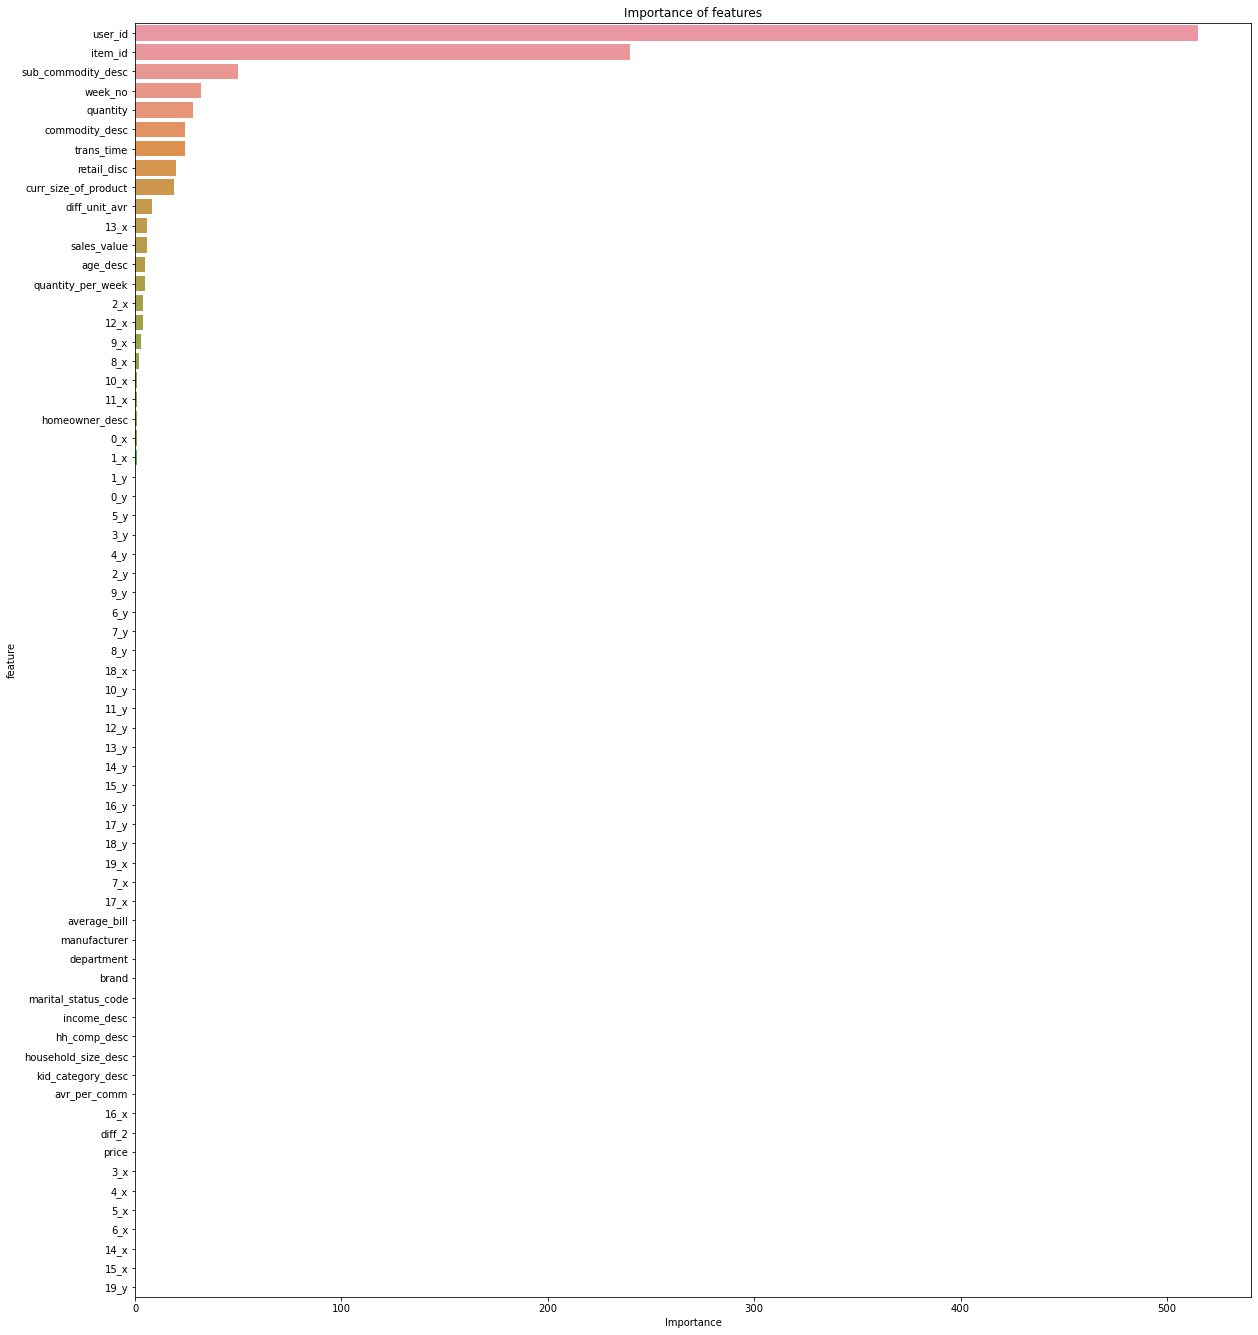

In [30]:
feat = show_feature_importances(X_val.columns, lgb.feature_importances_, get_top=50)

### Сортировка предсказаний

In [31]:
top = result_val[['user_id', 'item_id', 'target']]
top['score'] = [x for x in val_preds]
top = top.sort_values(['user_id', 'score'], ascending=False)

C:\Users\Eugene\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Финальная таблица

In [32]:
total_result = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
total_result.columns=['user_id', 'actual']
total_result.reset_index(inplace=True)
grouped = top.groupby('user_id')['item_id'].unique()
total_result['lightGBM'] = total_result.merge(grouped, how='left', on='user_id')['item_id']
total_result['recomendations'] = total_result.apply(lambda x: postfilter_items(x['user_id'], x['lightGBM'], 1, recommender, item_id_to_price, item_id_to_sub_commodity, user_purchased_items), axis=1)
total_result.drop(columns=['index'], inplace=True)
total_result

,user_id,actual,lightGBM,recomendations
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[856942, 995242, 931136, 940947, 1055201, ...,...","[1000753, 1133018, 856942, 931136, 940947]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1053690, 921345, 910032, 1106523, 1092026, .....","[874972, 995242, 981760, 1053690, 921345]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1119051, 981760, 1037863, 1024306, 845208, .....","[1000753, 1106523, 1119051, 981760, 1037863]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1106523, 1133018, 1122358, 961554, 828867, .....","[1000753, 981760, 1106523, 1122358, 961554]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[950824, 1005186, 969932, 1127624, 1133018, .....","[874972, 908531, 950824, 1005186, 969932]"
...,...,...,...,...
2037,2496,[6534178],"[1106523, 5569230, 916122, 1056509, 981760, .....","[1000753, 995242, 1127831, 5569230, 916122]"
2038,2497,"[1016709, 9835695, 1132298, 16809501, 845294, ...","[995242, 1029743, 1135834, 962568, 870515, ......","[1000753, 1133018, 908531, 1135834, 962568]"
2039,2498,"[15716530, 834484, 901776, 914190, 958382, 972...","[1070820, 1106523, 1005186, 1053690, 1100379, ...","[933354, 1000753, 995242, 1005186, 1053690]"
2040,2499,"[867188, 877580, 902396, 914190, 951590, 95813...","[1070820, 5570048, 5568378, 944317, 866528, .....","[1000753, 995242, 5570048, 5568378, 944317]"


### Результат

In [33]:
total_result.apply(lambda x: money_precision_at_k(x['recomendations'], x['actual'], item_id_to_price, 5), axis=1).mean()

0.12838747296384276

### Сохранение результатов

In [34]:
total_result.drop(['actual', 'lightGBM'], axis=1, inplace=True)

In [35]:
total_result.to_csv('recommendations.csv', index=False)